In [146]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.stats import kstest, shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
%matplotlib inline

In [147]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [148]:
def test_normality(data):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    sb.distplot(data)
    plt.show()
    ks_stat, ks_p = kstest(data, "norm")
    print("Kolmogorov-Smirnov Test Results: ")
    print("Test Statistics = ", ks_stat)
    print("P-value = ", ks_p)
    if ks_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")
    print("------------------------------------------------")
    sh_stat, sh_p = shapiro(data)
    print("Shapiro-Wilk Test Results: ")
    print("Test Statistics = ", sh_stat)
    print("P-value = ", sh_p)
    if sh_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")    

In [149]:
def plot(data_label_pairs, x_label, y_label, title):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    for data, label in data_label_pairs:
        plt.plot(data, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [150]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back]
        data_x.append(data_window)
        data_y.append(data[i + look_back])
    return np.array(data_x), np.array(data_y)

In [151]:
def performance(actual, predicted):
    print("Performance:")
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    print("mean squared error: ", mse)
    print("root mean square error: ", rmse)
    print("mean absolute error: ", mae)
    print("mean absolute percentage error: ", mape, "%")

In [152]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
# ether_data.interpolate(inplace=True)
dates = list(ether_data.index)

In [153]:
ether_data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-03-10,11.20,11.85,11.07,11.75,0.0,0.0491
2016-03-11,11.75,11.95,11.75,11.95,180.0,0.0170
2016-03-12,11.95,13.45,11.95,12.92,830.0,0.0812
2016-03-13,12.92,15.07,12.92,15.07,1300.0,0.1664
2016-03-14,15.07,15.07,11.40,12.50,92180.0,-0.1705
...,...,...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46,899820.0,-0.0657
2022-05-06,2747.60,2757.14,2635.85,2692.88,881180.0,-0.0199
2022-05-07,2692.92,2703.11,2589.29,2636.03,458050.0,-0.0211


In [154]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
 4   Volume  2244 non-null   float64
 5   Change  2252 non-null   float64
dtypes: float64(6)
memory usage: 123.2 KB


In [155]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2252.000000,2252.000000,2252.000000,2252.000000,2.244000e+03,2252.000000
mean,812.901239,841.363615,780.354378,813.961607,1.327576e+07,0.003973
std,1163.234596,1199.773415,1120.483259,1163.604697,1.038937e+08,0.056057
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.372500,139.487500,130.700000,135.460000,5.336425e+05,-0.022300
50%,258.000000,268.905000,242.690000,258.900000,1.485000e+06,0.001100
75%,754.400000,798.180000,719.557500,759.147500,7.980000e+06,0.029425
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


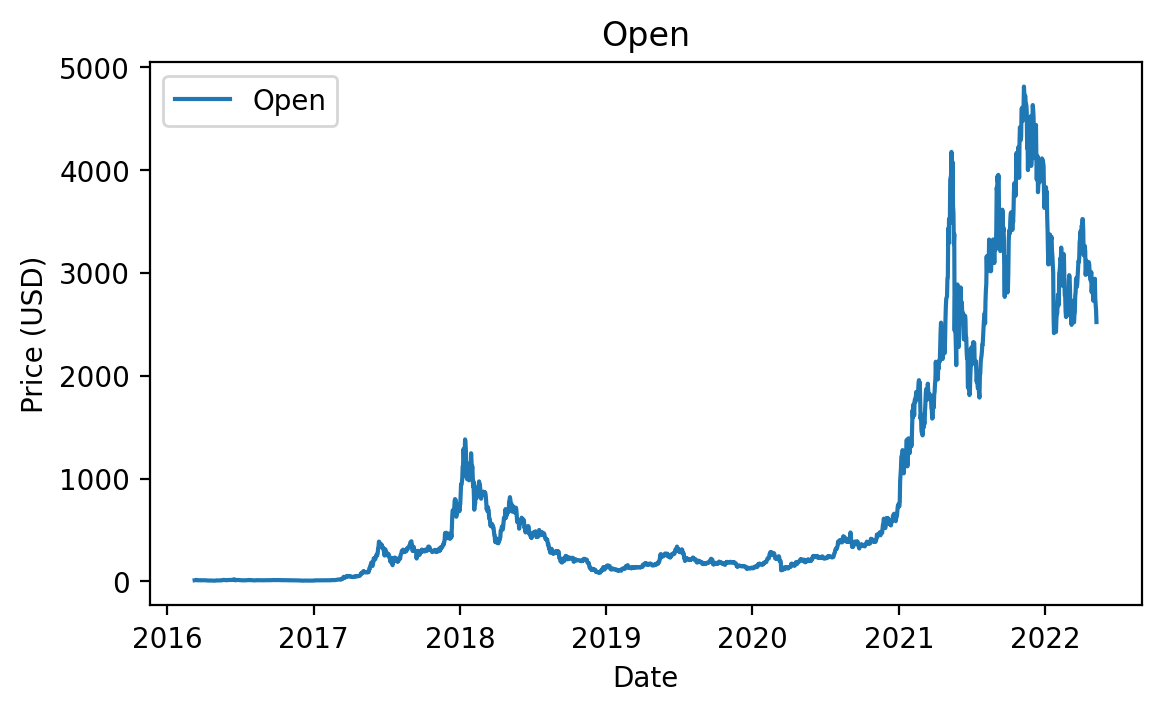

In [156]:
plot(data_label_pairs=[(ether_data["Open"], "Open")], x_label="Date", y_label="Price (USD)", title="Open")

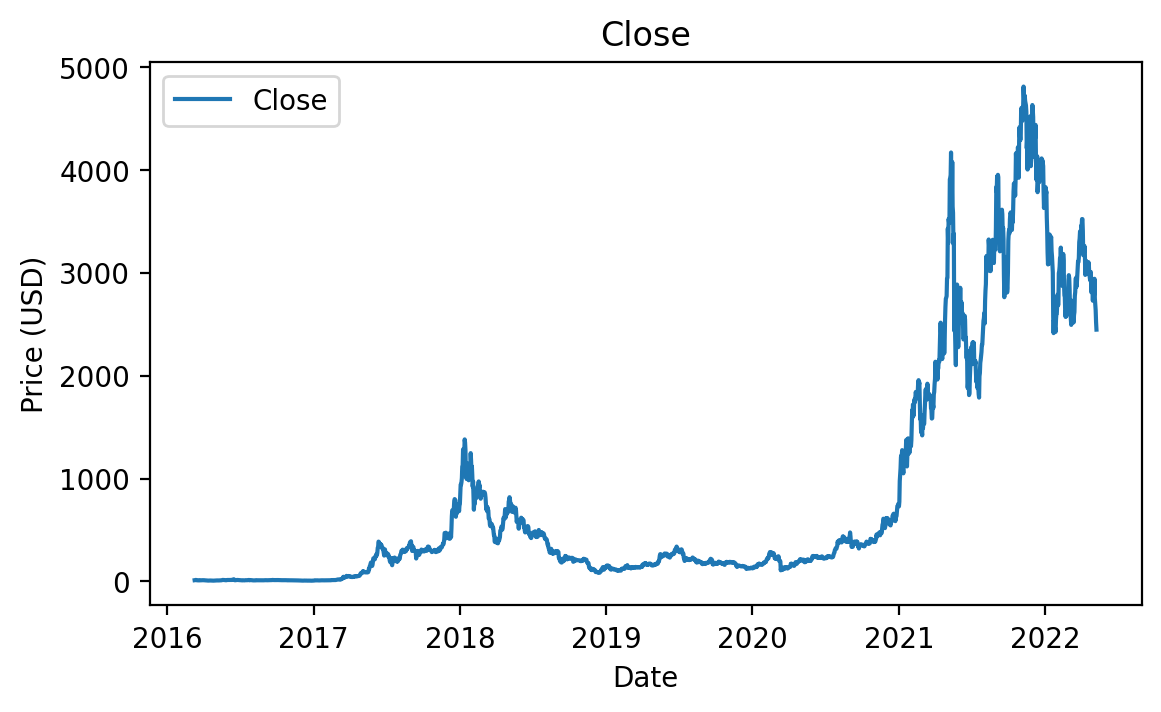

In [157]:
plot(data_label_pairs=[(ether_data["Close"], "Close")], x_label="Date", y_label="Price (USD)", title="Close")

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


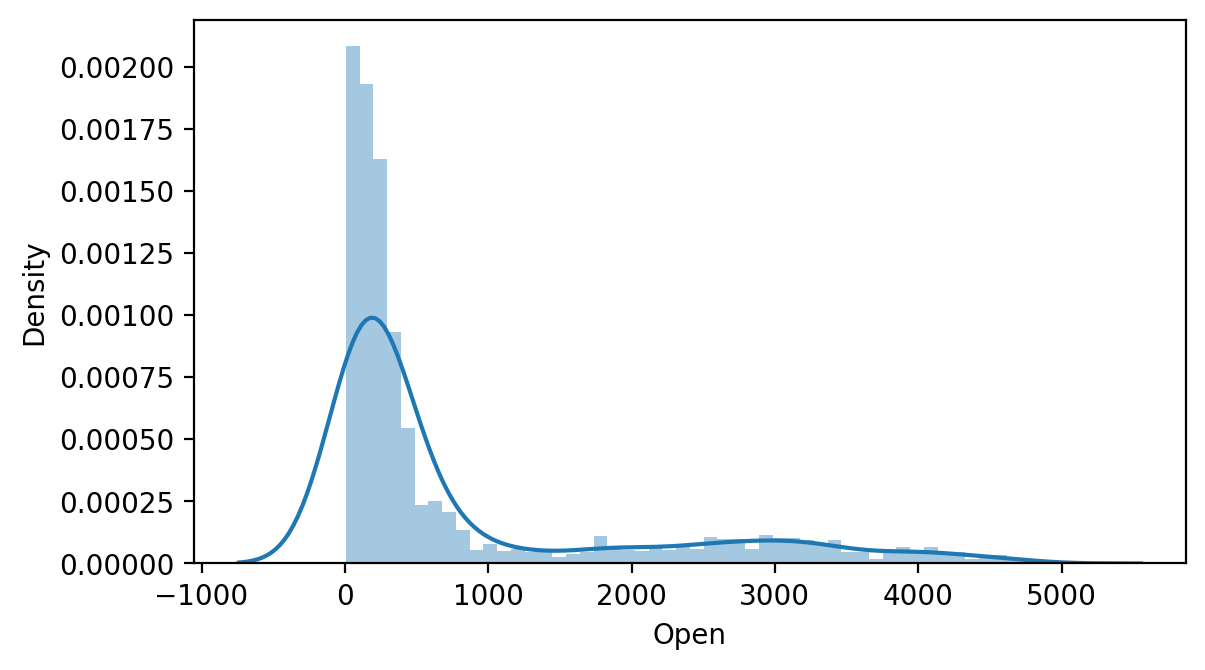

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999999880529
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6839131116867065
P-value =  0.0
Not Gausssian.


In [158]:
test_normality(ether_data["Open"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


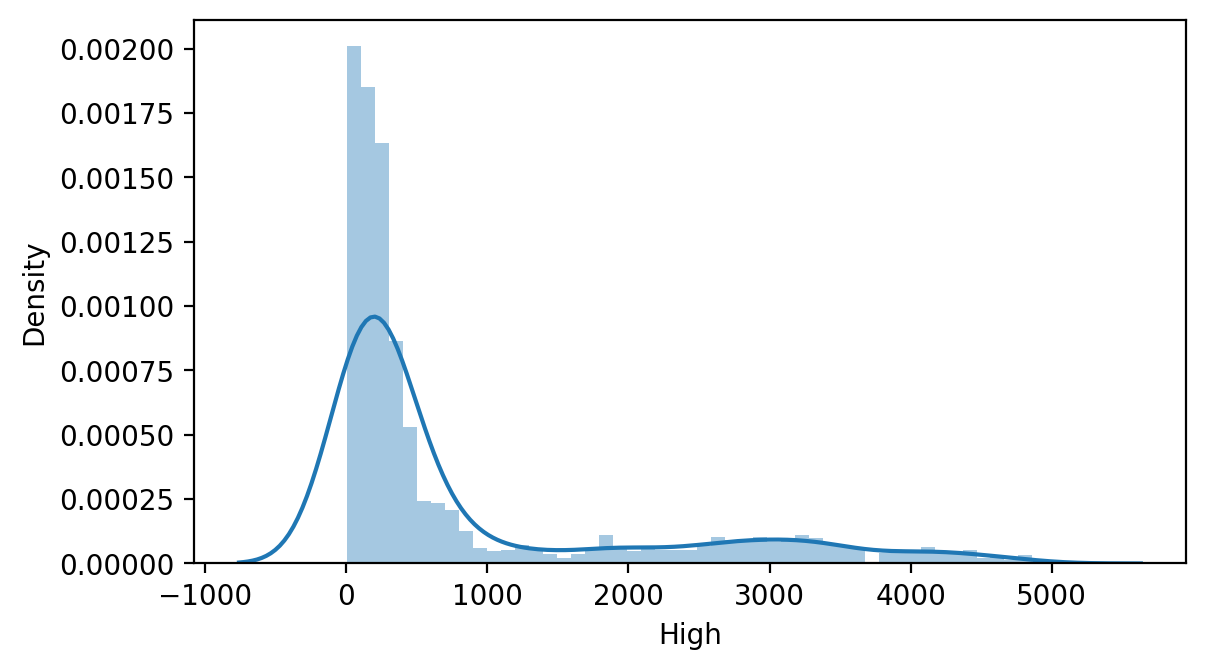

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999999876
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.685326099395752
P-value =  0.0
Not Gausssian.


In [159]:
test_normality(ether_data["High"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


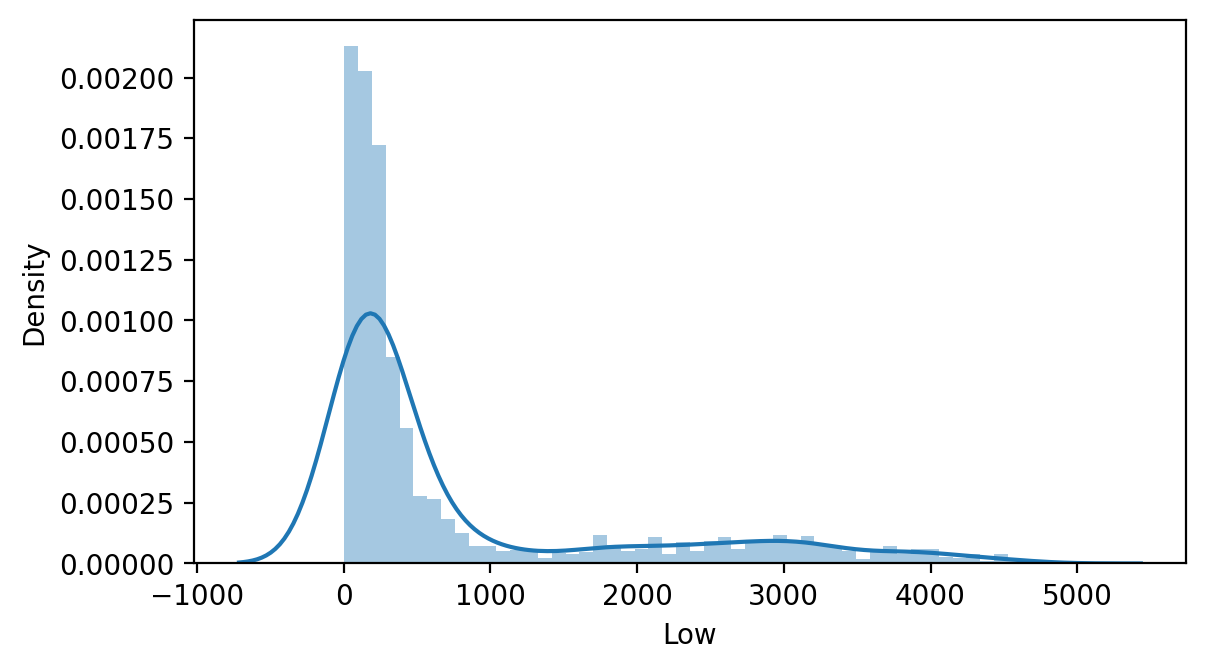

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999976856642
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6821624040603638
P-value =  0.0
Not Gausssian.


In [160]:
test_normality(ether_data["Low"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


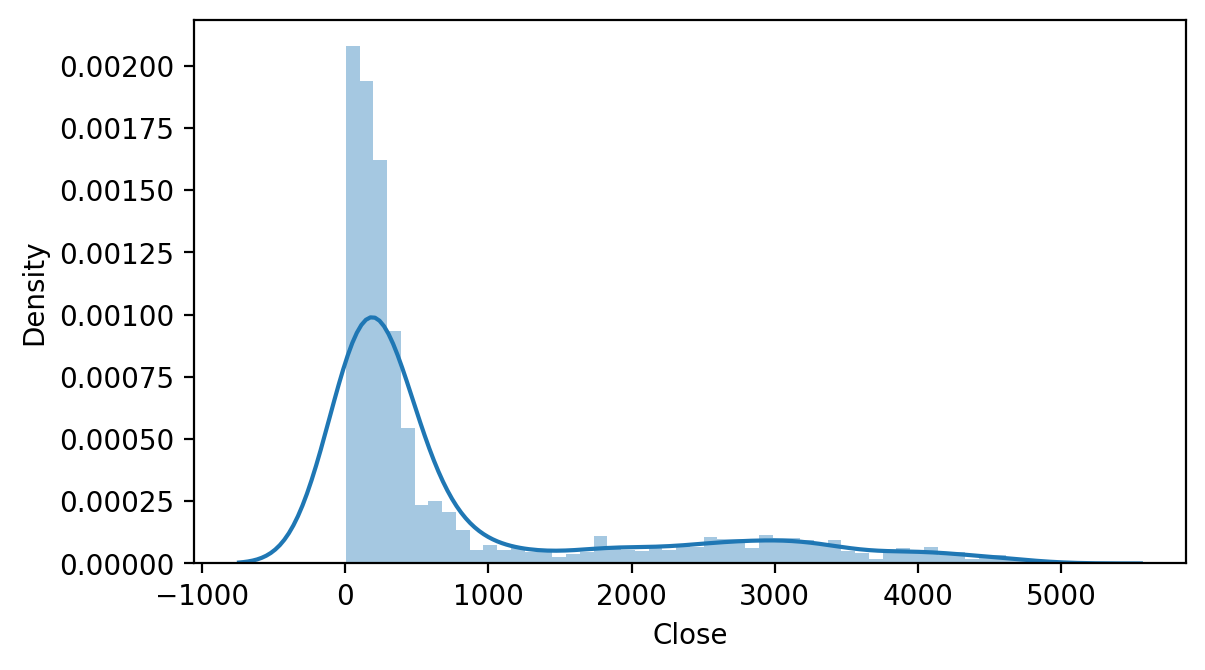

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999989579
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6844182014465332
P-value =  0.0
Not Gausssian.


In [161]:
test_normality(ether_data['Close'])

In [162]:
ether_data_uni = pd.DataFrame(ether_data, columns=["Close"])

In [163]:
ether_data_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [164]:
ether_data_uni.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2252 non-null   float64
dtypes: float64(1)
memory usage: 35.2 KB


In [165]:
ether_data_uni.describe()

,Close
count,2252.000000
mean,813.961607
std,1163.604697
min,6.700000
25%,135.460000
50%,258.900000
75%,759.147500
max,4808.380000


In [166]:
uni_training_size = int(len(ether_data_uni) * 0.90)
uni_test_size = len(ether_data_uni) - uni_training_size
train_ether_uni = ether_data_uni[:uni_training_size]
test_ether_uni = ether_data_uni[uni_training_size:]

In [167]:
train_ether_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2021-09-21,2761.52
2021-09-22,3077.78
2021-09-23,3152.92


In [168]:
test_ether_uni

,Close
Date,
2021-09-26,3063.51
2021-09-27,2926.24
2021-09-28,2807.28
2021-09-29,2851.50
2021-09-30,3000.59
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [169]:
# standard_scaler = StandardScaler()
# scaled_train_uni = standard_scaler.fit_transform(train_ether_uni)
# scaled_test_uni = standard_scaler.fit_transform(test_ether_uni)
minmax_scaler = MinMaxScaler()
scaled_train_uni = minmax_scaler.fit_transform(train_ether_uni)
scaled_test_uni = minmax_scaler.fit_transform(test_ether_uni)

In [170]:
scaled_train_uni.shape

(2026, 1)

In [171]:
scaled_test_uni.shape

(226, 1)

In [356]:
uni_train_x, uni_train_y = prepare_for_lstm(scaled_train_uni, 3)
uni_test_x, uni_test_y = prepare_for_lstm(scaled_test_uni, 3)
uni_train_x = uni_train_x.reshape((-1, uni_train_x.shape[1], 1))
uni_test_x = uni_test_x.reshape((-1, uni_test_x.shape[1], 1))

In [357]:
# inversed_actual = standard_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual = minmax_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
actual_uni = pd.DataFrame(data=inversed_actual, index=dates[-1 * len(inversed_actual):], columns=["Close"])
actual_uni.index.name = "Date"

In [355]:
uni_train_x.shape, uni_train_y.shape

((2023, 3, 1), (2023, 1))

In [251]:
uni_test_x.shape, uni_test_y.shape

((219, 7, 1), (219, 1))

In [252]:
actual_uni

,Close
Date,
2021-10-03,3417.34
2021-10-04,3382.90
2021-10-05,3517.26
2021-10-06,3575.41
2021-10-07,3586.00
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [253]:
vanilla_model = tf.keras.models.Sequential()
vanilla_model.add(tf.keras.layers.LSTM(units=128, activation="relu", input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
vanilla_model.add(tf.keras.layers.Dense(units=1))
vanilla_model.summary()
vanilla_model.compile(optimizer="adam", loss="mse")
vanilla_results = vanilla_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 128)               66560     
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
64/64 [==============================] - 2s 13ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 2/50
64/64 [==============================] - 1s 11ms/step - loss: 5.5519e-04 - val_loss: 0.0066
Epoch 3/50
64/64 [==============================] - 1s 9ms/step - loss: 5.2995e-04 - val_loss: 0.0065
Epoch 4/50
64/64 [==============================] - 1s 9ms/step - loss: 4.9120e-04 - val_loss: 0.0067
Epoch 5/50
64/64 [=====================

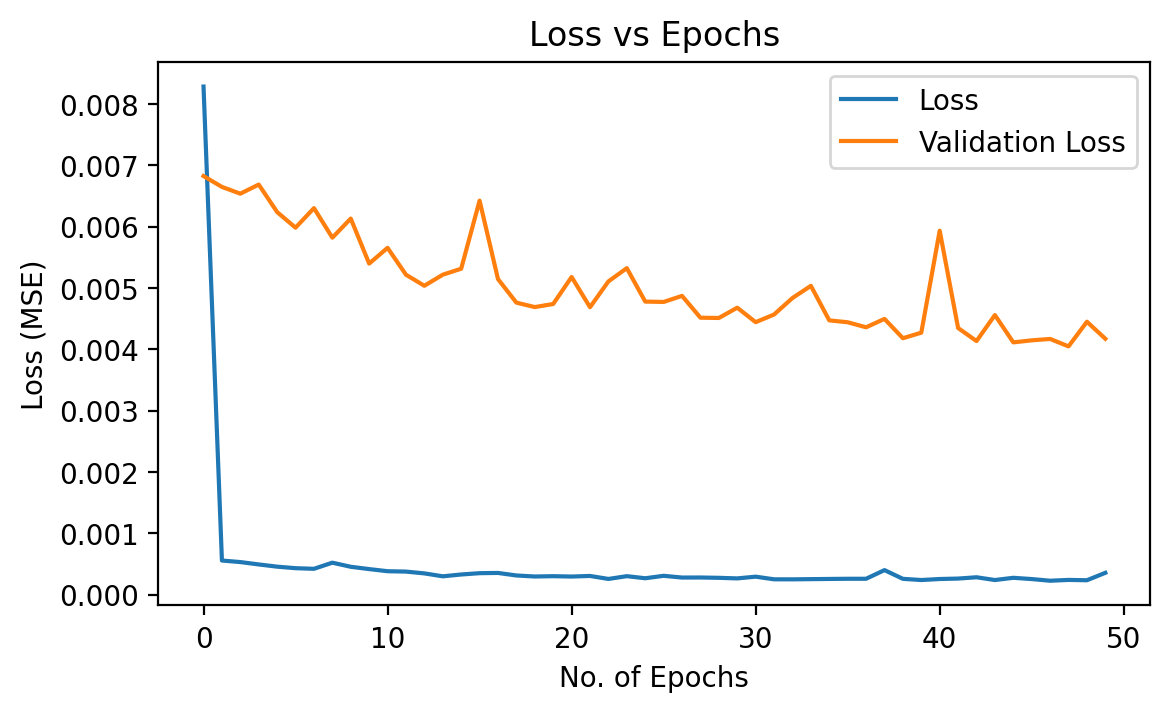

In [254]:
plot(data_label_pairs=[(vanilla_results.history["loss"], "Loss"), (vanilla_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [255]:
# predicted_vanilla =  pd.DataFrame(data=standard_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla =  pd.DataFrame(data=minmax_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [256]:
predicted_vanilla

,Predicted_Close
Date,
2021-10-03,3241.821533
2021-10-04,3349.411621
2021-10-05,3394.719482
2021-10-06,3487.248291
2021-10-07,3571.731934
...,...
2022-05-05,2885.812012
2022-05-06,2844.073242
2022-05-07,2783.557617


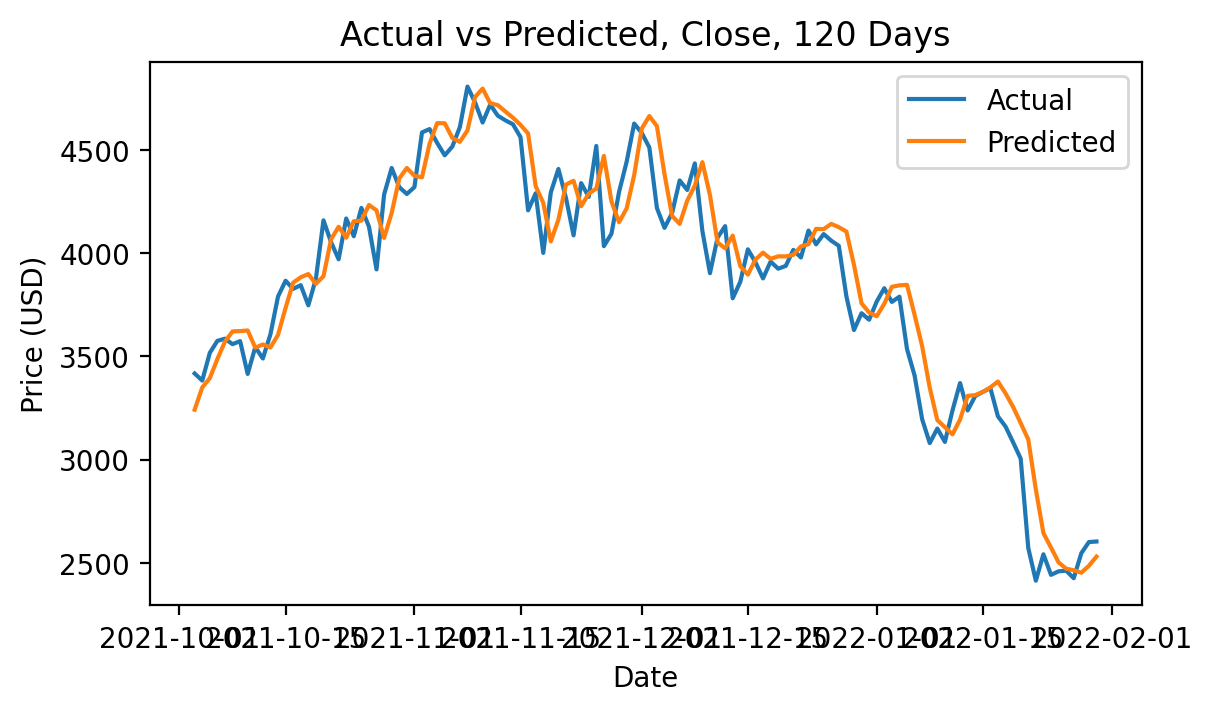

In [257]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_vanilla["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [258]:
performance(actual_uni["Close"][:120], predicted_vanilla["Predicted_Close"][:120])

Performance:
mean squared error:  29397.041172114303
root mean square error:  171.45565366039787
mean absolute error:  130.1017179361979
mean absolute percentage error:  3.5160141560507063 %


In [259]:
stacked_model = tf.keras.models.Sequential()
stacked_model.add(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True,  input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
stacked_model.add(tf.keras.layers.LSTM(units=64, activation="relu"))
stacked_model.add(tf.keras.layers.Dense(units=1))
stacked_model.summary()
stacked_model.compile(optimizer="adam", loss="mse")
stacked_results = stacked_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_89 (LSTM)              (None, 7, 128)            66560     
                                                                 
 lstm_90 (LSTM)              (None, 64)                49408     
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
64/64 [==============================] - 4s 25ms/step - loss: 0.0131 - val_loss: 0.0091
Epoch 2/50
64/64 [==============================] - 1s 17ms/step - loss: 8.3695e-04 - val_loss: 0.0091
Epoch 3/50
64/64 [==============================] - 1s 15ms/step - loss: 7.2811e-04 - val_loss: 0.0096
Epoch 

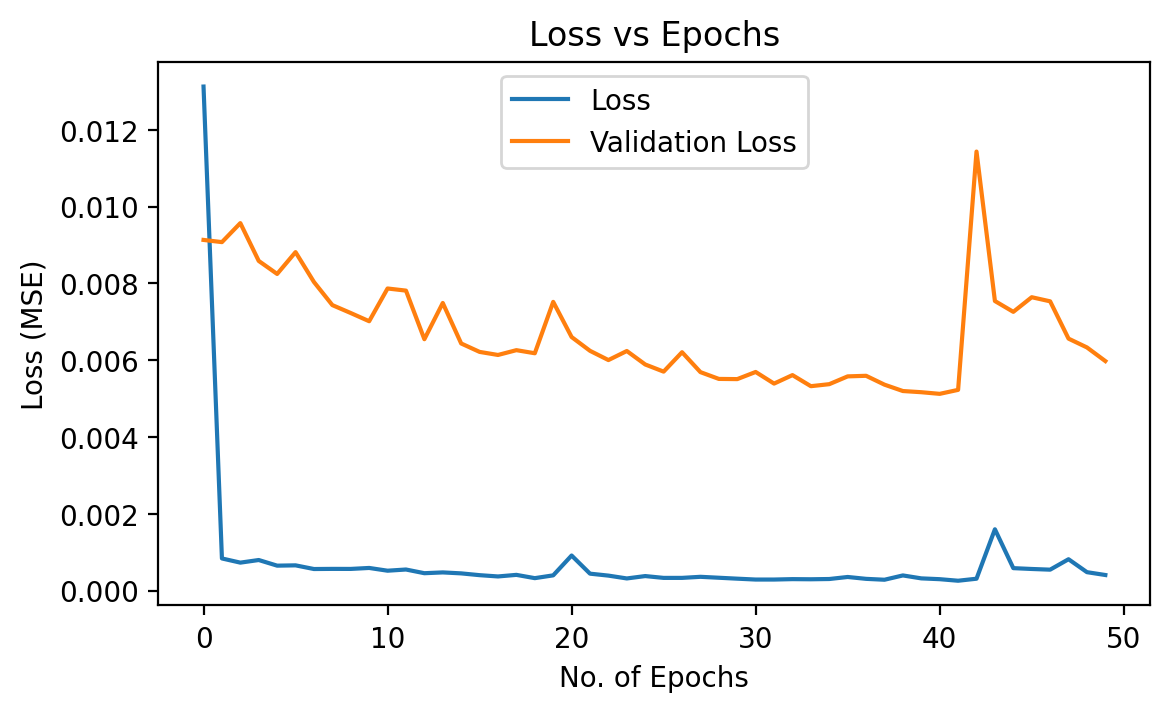

In [260]:
plot(data_label_pairs=[(stacked_results.history["loss"], "Loss"), (stacked_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [261]:
# predicted_stacked =  pd.DataFrame(data=standard_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked =  pd.DataFrame(data=minmax_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked.index.name = "Date"

In [262]:
predicted_stacked

,Predicted_Close
Date,
2021-10-03,3097.019775
2021-10-04,3207.034912
2021-10-05,3303.440430
2021-10-06,3396.671387
2021-10-07,3482.028076
...,...
2022-05-05,2840.358887
2022-05-06,2834.476562
2022-05-07,2816.686768


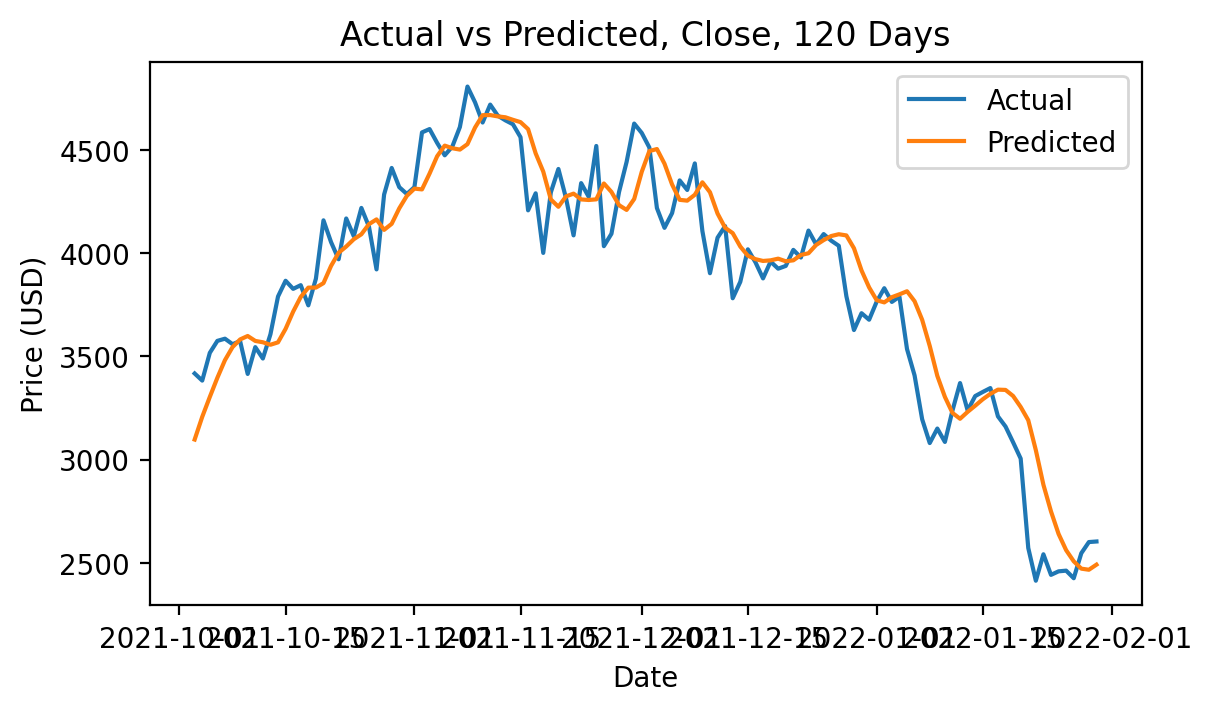

In [263]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [264]:
performance(actual_uni, predicted_stacked)

Performance:
mean squared error:  34313.03874931695
root mean square error:  185.23778974420136
mean absolute error:  144.3694301601741
mean absolute percentage error:  4.468279830427793 %


In [265]:
bidirectional_model = tf.keras.models.Sequential()
bidirectional_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation="sigmoid"), input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
bidirectional_model.add(tf.keras.layers.Dense(units=1))
bidirectional_model.summary()
bidirectional_model.compile(optimizer="adam", loss="mse")
bidirectional_results = bidirectional_model.fit(uni_train_x, uni_train_y, batch_size=256, epochs=30, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirecti  (None, 256)              133120    
 onal)                                                           
                                                                 
 dense_28 (Dense)            (None, 1)                 257       
                                                                 
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
8/8 [==============================] - 3s 114ms/step - loss: 0.4873 - val_loss: 0.1556
Epoch 2/30
8/8 [==============================] - 1s 63ms/step - loss: 0.1922 - val_loss: 0.2240
Epoch 3/30
8/8 [==============================] - 0s 59ms/step - loss: 0.0948 - val_loss: 0.2954
Epoch 4/30
8/8 [==============================] - 0s 59ms/step - loss: 0.0425 - val_l

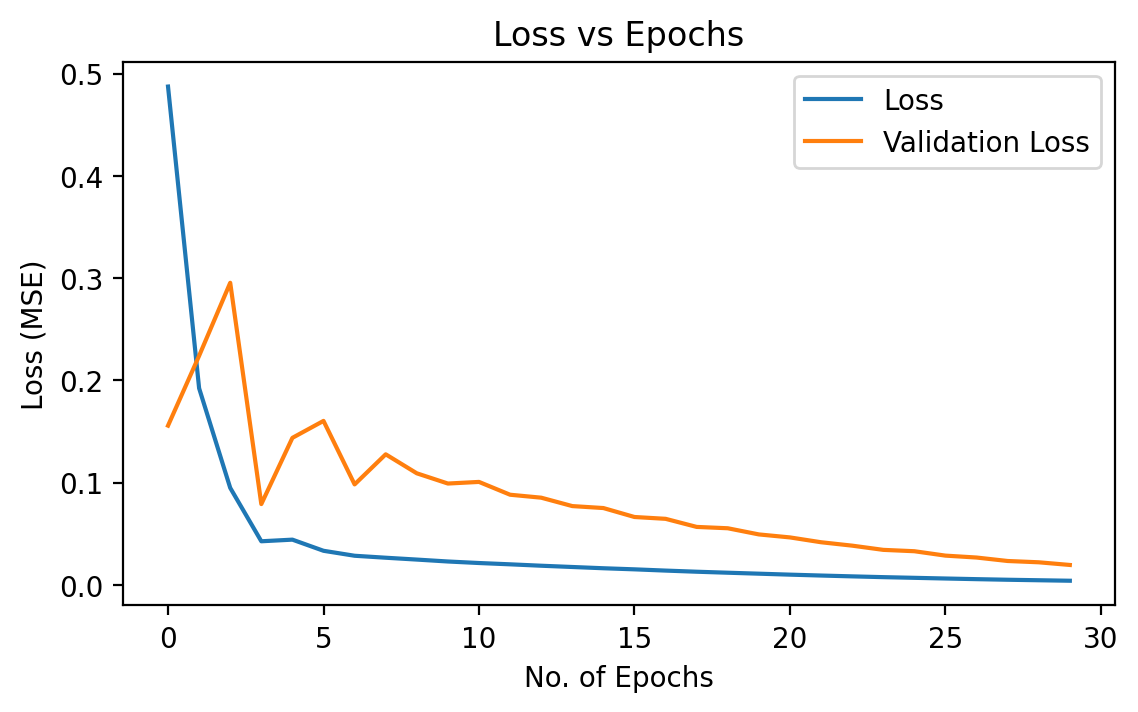

In [266]:
plot(data_label_pairs=[(bidirectional_results.history["loss"], "Loss"), (bidirectional_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [267]:
# predicted_bidirectional =  pd.DataFrame(data=standard_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional =  pd.DataFrame(data=minmax_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional.index.name = "Date"

In [268]:
predicted_bidirectional

,Predicted_Close
Date,
2021-10-03,3038.861328
2021-10-04,3029.009521
2021-10-05,3013.382324
2021-10-06,3078.867676
2021-10-07,3153.361572
...,...
2022-05-05,2852.937500
2022-05-06,2779.255859
2022-05-07,2742.570801


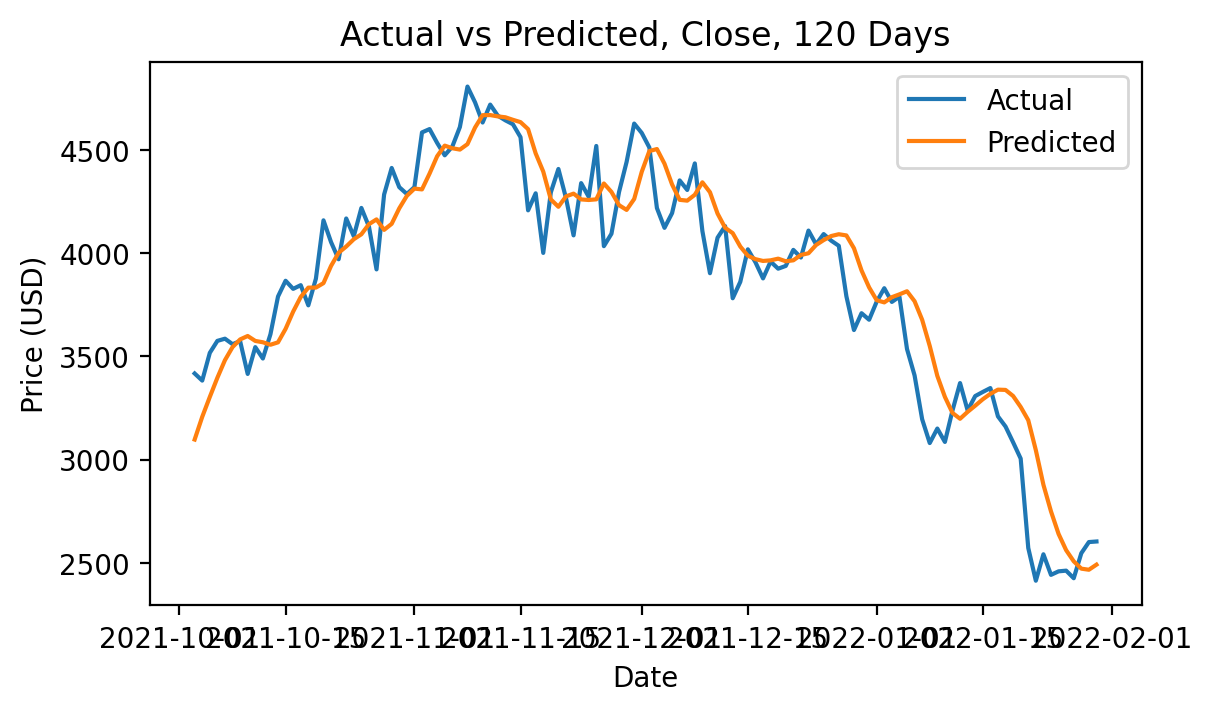

In [269]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [270]:
performance(actual_uni, predicted_bidirectional)

Performance:
mean squared error:  111093.48530225497
root mean square error:  333.3068935714576
mean absolute error:  266.03894558005135
mean absolute percentage error:  7.246319599561925 %


In [271]:
ether_data.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999374,0.998569,0.998238,0.104393,-0.032946
High,0.999374,1.000000,0.998477,0.999155,0.104659,-0.017002
Low,0.998569,0.998477,1.000000,0.999118,0.106196,-0.012295
Close,0.998238,0.999155,0.999118,1.000000,0.105048,0.000184
Volume,0.104393,0.104659,0.106196,0.105048,1.000000,0.000199
Change,-0.032946,-0.017002,-0.012295,0.000184,0.000199,1.000000


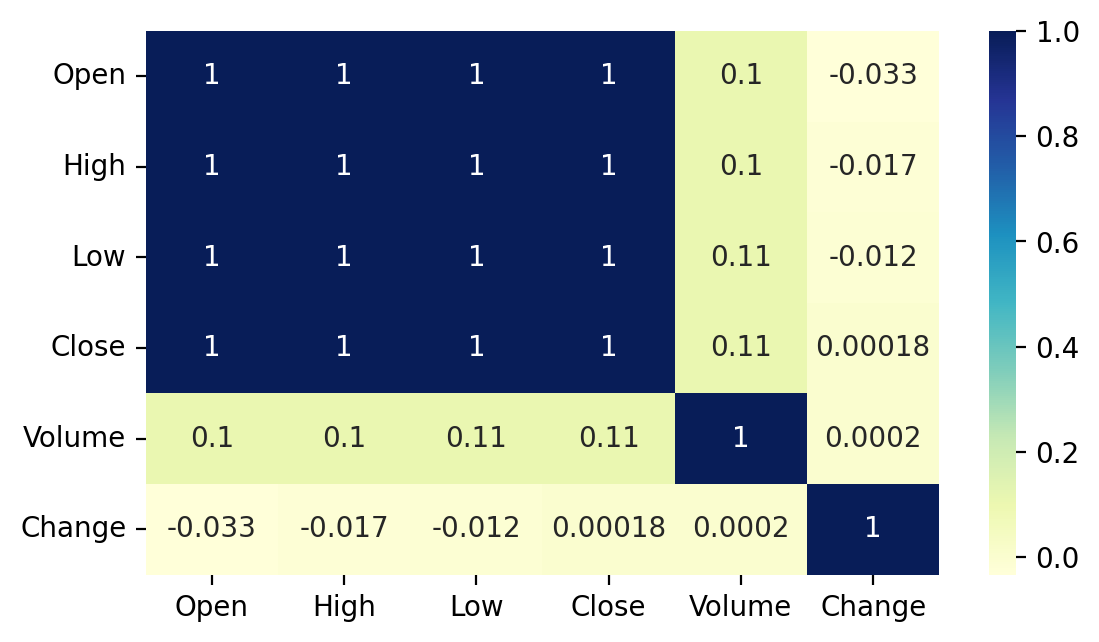

In [272]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.heatmap(ether_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [273]:
ether_data_multi = pd.DataFrame(ether_data, columns=["Open", "High", "Low", "Close"])

In [274]:
ether_data_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [275]:
ether_data_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
dtypes: float64(4)
memory usage: 88.0 KB


In [276]:
ether_data_multi.describe()

,Open,High,Low,Close
count,2252.000000,2252.000000,2252.000000,2252.000000
mean,812.901239,841.363615,780.354378,813.961607
std,1163.234596,1199.773415,1120.483259,1163.604697
min,6.680000,7.320000,5.860000,6.700000
25%,135.372500,139.487500,130.700000,135.460000
50%,258.000000,268.905000,242.690000,258.900000
75%,754.400000,798.180000,719.557500,759.147500
max,4808.340000,4864.060000,4715.430000,4808.380000


In [277]:
multi_training_size = int(len(ether_data_multi) * 0.90)
multi_test_size = len(ether_data_multi) - multi_training_size
train_ether_multi = ether_data_multi[:multi_training_size]
test_ether_multi = ether_data_multi[multi_training_size:]

In [278]:
train_ether_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2021-09-21,2976.70,3101.88,2659.71,2761.52
2021-09-22,2764.71,3087.97,2740.58,3077.78
2021-09-23,3077.80,3173.00,3035.96,3152.92


In [279]:
test_ether_multi

,Open,High,Low,Close
Date,,,,
2021-09-26,2922.47,3113.65,2740.12,3063.51
2021-09-27,3061.86,3163.86,2926.24,2926.24
2021-09-28,2926.04,2969.18,2791.42,2807.28
2021-09-29,2807.15,2948.50,2784.66,2851.50
2021-09-30,2851.06,3047.08,2837.68,3000.59
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [280]:
# standard_scaler_multi = StandardScaler()
# scaled_train_multi = standard_scaler_multi.fit_transform(train_ether_multi)
# scaled_test_multi = standard_scaler_multi.fit_transform(test_ether_multi)
minmax_scaler_multi = MinMaxScaler()
scaled_train_multi = minmax_scaler_multi.fit_transform(train_ether_multi)
scaled_test_multi = minmax_scaler_multi.fit_transform(test_ether_multi)

In [281]:
scaled_train_multi.shape

(2026, 4)

In [282]:
scaled_test_multi.shape

(226, 4)

In [341]:
multi_train_x, multi_train_y = prepare_for_lstm(scaled_train_multi, 3)
multi_test_x, multi_test_y = prepare_for_lstm(scaled_test_multi, 3)

In [342]:
multi_train_x.shape, multi_train_y.shape

((2023, 3, 4), (2023, 4))

In [343]:
multi_test_x.shape, multi_test_y.shape

((223, 3, 4), (223, 4))

In [344]:
# inversed_actual_multi = standard_scaler_multi.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual_multi = minmax_scaler_multi.inverse_transform(multi_test_y)
actual_multi = pd.DataFrame(data=inversed_actual_multi, index=dates[-1 * len(inversed_actual_multi):], columns=["Open", "High", "Low", "Close"])
actual_multi.index.name = "Date"

In [345]:
actual_multi

,Open,High,Low,Close
Date,,,,
2021-09-29,2807.15,2948.50,2784.66,2851.50
2021-09-30,2851.06,3047.08,2837.68,3000.59
2021-10-01,2999.86,3329.32,2972.75,3309.13
2021-10-02,3309.14,3467.95,3265.97,3388.97
2021-10-03,3388.83,3485.48,3346.63,3417.34
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [346]:
multi_model = tf.keras.models.Sequential()
multi_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, activation="sigmoid", return_sequences=True), input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.4))
multi_model.add(tf.keras.layers.LSTM(units=32, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.4))
multi_model.add(tf.keras.layers.Dense(units=multi_train_x.shape[2]))
multi_model.summary()
multi_model.compile(optimizer="adam", loss="mse")
multi_results = multi_model.fit(multi_train_x, multi_train_y, batch_size=256, epochs=50, verbose=1, validation_data=(multi_test_x, multi_test_y))

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_31 (Bidirecti  (None, 3, 128)           35328     
 onal)                                                           
                                                                 
 dropout_100 (Dropout)       (None, 3, 128)            0         
                                                                 
 lstm_113 (LSTM)             (None, 32)                20608     
                                                                 
 dropout_101 (Dropout)       (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 4)                 132       
                                                                 
Total params: 56,068
Trainable params: 56,068
Non-trainable params: 0
_________________________________________________

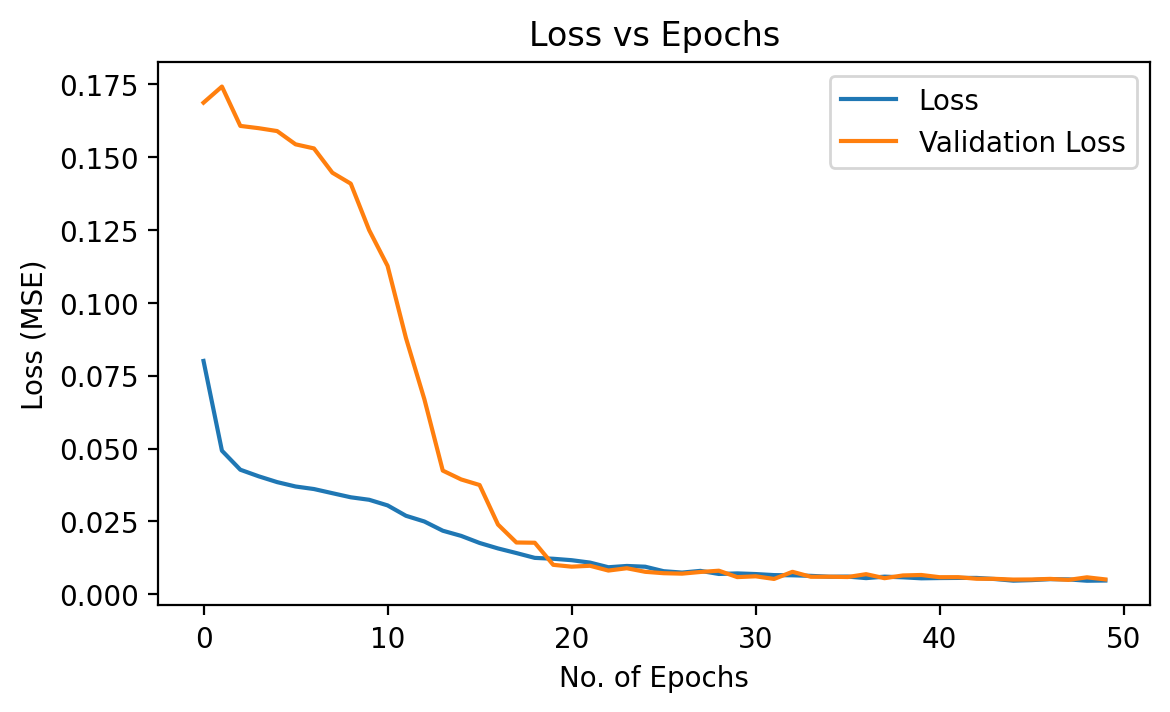

In [347]:
plot(data_label_pairs=[(multi_results.history["loss"], "Loss"), (multi_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [348]:
# predicted_multi =  pd.DataFrame(data=standard_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_multi =  pd.DataFrame(data=minmax_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [349]:
predicted_multi

,Predicted_Open,Predicted_High,Predicted_Low,Predicted_Close
2021-09-29,2864.813965,2948.551270,2658.160645,2863.925049
2021-09-30,2825.321289,2909.637207,2615.369385,2825.427490
2021-10-01,2805.326660,2889.884521,2593.167969,2804.747559
2021-10-02,2897.678223,2980.607422,2692.947998,2893.578857
2021-10-03,3077.094238,3156.666504,2887.502441,3068.525391
...,...,...,...,...
2022-05-05,2763.953369,2849.037354,2548.234131,2764.455566
2022-05-06,2767.889404,2853.008789,2552.543701,2768.427979
2022-05-07,2735.959717,2821.306641,2518.161377,2737.968750
2022-05-08,2681.015137,2766.874023,2458.373291,2684.050781


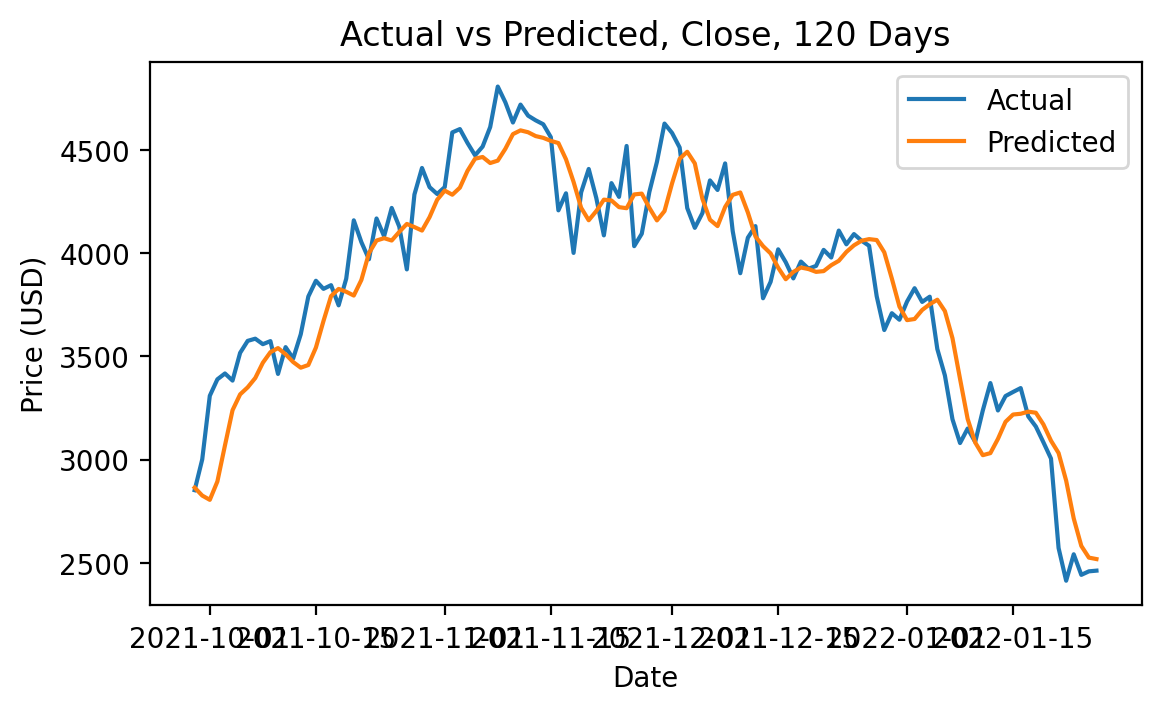

In [350]:
plot(data_label_pairs=[(actual_multi["Close"][:120], "Actual"), (predicted_multi["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [351]:
performance(actual_multi["Close"], predicted_multi["Predicted_Close"])

Performance:
mean squared error:  32741.688253796037
root mean square error:  180.9466447707612
mean absolute error:  143.7440639451373
mean absolute percentage error:  4.2661963472842706 %
